In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video

In [25]:
res = 20  # resolution pixels/um

eps = 13  # dielectric constant of waveguide
w = 1.2  # width of waveguide
r = 2 # radius of holes
d = 5 # defect spacing (ordinary spacing = 1)
N = 6 # number of holes on either side of defect

sy = 50 # size of cell in y direction (perpendicular to wvg.)
pad = 2  # padding between last hole and PML edge
dpml = 5  # PML thickness
nfreq = 500  # number of frequencies at which to compute flux

sx =20 # size of cell in x direction


-----------
Initializing structure...
Halving computational cell along direction x
time for choose_chunkdivision = 0.00141788 s
Working in 2D dimensions.
Computational cell is 20 x 50 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (-10,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (10,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (-5,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (5,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (13,13,13)
time for set_epsilon = 0.439256 s
-----------
Meep: using complex fields.
Meep progr

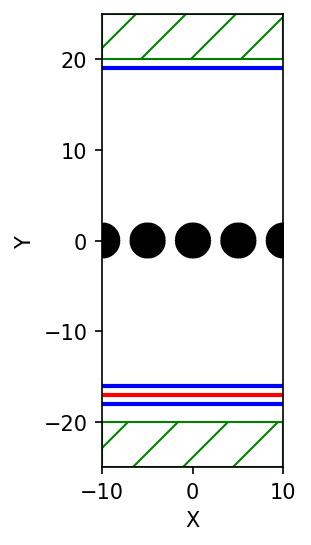

In [67]:
cell = mp.Vector3(sx, sy, 0) # cell size 

geometry = []
geometry.append(mp.Cylinder(r, center=mp.Vector3(0,0,0), material=mp.Medium(epsilon=eps)))
geometry.append(mp.Cylinder(r, center=mp.Vector3(-(sx/2),0,0), material=mp.Medium(epsilon=eps)))
geometry.append(mp.Cylinder(r, center=mp.Vector3((sx/2),0,0), material=mp.Medium(epsilon=eps)))
geometry.append(mp.Cylinder(r, center=mp.Vector3(-(sx/4),0,0), material=mp.Medium(epsilon=eps)))
geometry.append(mp.Cylinder(r, center=mp.Vector3((sx/4),0,0), material=mp.Medium(epsilon=eps)))


pml_layers = [mp.PML(thickness=dpml,direction=mp.Y)]

fcen = 0.25  # pulse center frequency
df = 50  # pulse frequency width


src = [mp.Source(mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True),
                     component=mp.Ex,
                     center=mp.Vector3(0,-((sy/2)-2*dpml+2),0),
                     size=mp.Vector3(sx,0,0))]
sym = [mp.Mirror(mp.X, phase=-1)]

sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    boundary_layers=pml_layers,
    sources=src,
    symmetries=sym,
    resolution=res,
    k_point=mp.Vector3((1/sx),0,0)
)

# freg1 = mp.FluxRegion(center=mp.Vector3(0,(sy/2-1.5*dpml)), size=mp.Vector3(sx,0))
# trans = sim.add_flux(fcen, df, nfreq, freg1)
# freg2 = mp.FluxRegion(center=mp.Vector3(0,-(sy/2-1.5*dpml)), size=mp.Vector3(sx,0))
# refl = sim.add_flux(fcen, df, nfreq, freg2)
# source = mp.FluxRegion(center=mp.Vector3(0,-4,0), size=mp.Vector3(sx,0))
# sourcef = sim.add_flux(fcen, df, nfreq, source)

# source flux
source_fr = mp.FluxRegion(center=mp.Vector3(0,-((sy/2)-2*dpml+1),0), size=mp.Vector3(sx,0,0))
source = sim.add_flux(fcen, df, nfreq, source_fr)

# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(0,-((sy/2)-2*dpml+3),0), size=mp.Vector3(sx,0,0))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(0,((sy/2)-dpml-1),0), size=mp.Vector3(sx,0,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

sim.run(until=200)

f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca())
plt.show()


In [68]:
source_data = mp.get_fluxes(source)
refl_data   = mp.get_fluxes(refl)
tran_data   = mp.get_fluxes(tran)

In [69]:
flux_freqs = mp.get_flux_freqs(source)

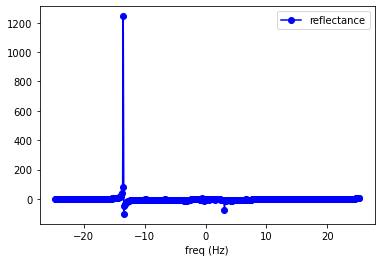

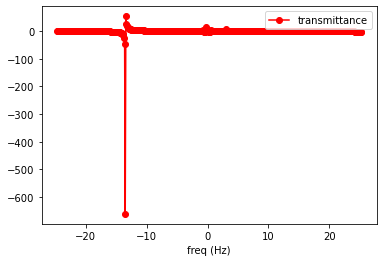

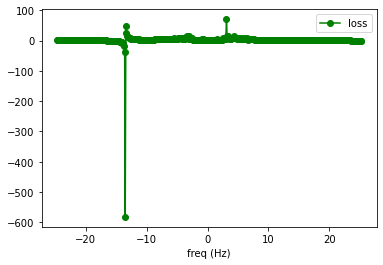

In [70]:
wl = []
Rs = []
Ts = []

for i in range(nfreq):
    wl = np.append(wl, flux_freqs[i])
    Rs = np.append(Rs,refl_data[i]/source_data[i])
    Ts = np.append(Ts,tran_data[i]/source_data[i])
if mp.am_master():
    plt.figure()
    plt.plot(wl,Rs,'bo-',label='reflectance')
    plt.xlabel("freq (Hz)")
    plt.legend(loc="upper right")
    plt.show()
    plt.plot(wl,Ts,'ro-',label='transmittance')
    plt.xlabel("freq (Hz)")
    plt.legend(loc="upper right")
    plt.show()
    plt.plot(wl,1-Rs-Ts,'go-',label='loss')
    plt.xlabel("freq (Hz)")
    plt.legend(loc="upper right")
    plt.show()